In [1]:
from fastai.vision.all import *
from timm import create_model
from fastai.vision.learner import _update_first_layer
from fastai.vision.learner import _add_norm

In [2]:
path = untar_data(URLs.PETS)
pat = r'/([^/]+)_\d+.*'
item_tfms = RandomResizedCrop(460, min_scale=0.75, ratio=(1.,1.))
batch_tfms = [*aug_transforms(size=224, max_warp=0), Normalize.from_stats(*imagenet_stats)]
bs=32
pets = DataBlock(blocks=(ImageBlock, CategoryBlock),
                 get_items=get_image_files,
                 splitter=RandomSplitter(0.2),
                 get_y=RegexLabeller(pat = pat),
                 item_tfms=item_tfms,
                 batch_tfms=batch_tfms)
dls = pets.dataloaders(path/'images', bs=bs)

In [3]:
def create_timm_body(arch:str, pretrained=True, cut=None, n_in=3):
    "Creates a body from any model in the `timm` library."
    model = create_model(arch, pretrained=pretrained, num_classes=0, global_pool='')
    _update_first_layer(model, n_in, pretrained)
    if cut is None:
        ll = list(enumerate(model.children()))
        cut = next(i for i,o in reversed(ll) if has_pool_type(o))
    if isinstance(cut, int): return nn.Sequential(*list(model.children())[:cut])
    elif callable(cut): return cut(model)
    else: raise NamedError("cut must be either integer or function")

In [4]:
def cnn_learner(dls, arch, loss_func=None, pretrained=True,
               cut=None, splitter=None, y_range=None, config=None,
               n_out=None, normalize=True, **kwargs):
    "Build a convnet style learner from `dls` and `arch`"
    if config is None: config={}
    meta = model_meta.get(arch, _default_meta)
    if n_out is None: n_out = get_c(dls)
    assert n_out,  "`n_out` is not defined, and could not be inferred from data, set `dls.c` or pass `n_out`"
    if normalize: _add_norm(dls, meta, pretrained)
    if y_range is None and 'y_range' in config: y_range = config.pop('y_range')
    model = create_cnn_model(arch, n_out, ifnone(cut, meta['cut']), pretrained, y_range=y_range, **config)
    learn=Learner(dls, model, loss_func, splitter=ifnone(splitter, meta['split'], **kwargs))
    if pretrained: learn.freeze()
    return learn

In [5]:
def create_timm_model(arch:str, n_out, cut=None, pretrained=True, n_in=3,
                     init=nn.init.kaiming_normal_, custom_head=None, concat_pool=True, **kwargs):
    "Create custom architecture using `arch`, `n_in` and `n_out` from `timm` library"
    body = create_timm_body(arch, pretrained, None, n_in)
    if custom_head is None:
        nf = num_features_model(nn.Sequential(*body.children())) * (2 if concat_pool else 1)
        head = create_head(nf, n_out, concat_pool=concat_pool, **kwargs)
    else: head = custom_head
    model  = nn.Sequential(body, head)
    if init is not None: apply_init(model[1], init)
    return model

In [6]:
def timm_learner(dls, arch:str, loss_func=None, pretrained=True, cut=None, splitter=None,
                y_range=None, config=None, n_out=None, normalize=True, **kwargs):
    "Build a convnet style learner from `dls` and `arch` using the `timm` library"
    if config is None: config = {}
    if n_out is None: n_out = get_c(dls)
    assert n_out, "`n_out` is not defined, and could not be inferred from data, set `dls.c` or pass `n_out`"
    if y_range is None and 'y_range' in config: y_range = config.pop('y_range')
    model = create_timm_model(arch, n_out, default_split, pretrained, y_range=y_range, **config)
    learn = Learner(dls, model, loss_func=loss_func, splitter=default_split, **kwargs)
    if pretrained: learn.freeze()
    return learn

In [7]:
#mixup = MixUp(0.5)

In [8]:
# def tst_param(val, grad=None):
#     "Create a tensor with `val` and a gradient of `grad` for testing"
#     res = tensor([val]).float()
#     res.grad = tensor([val/10 if grad is None else grad]).float()
#     return res

# params = tst_param([1,2,3], [0.1,0.2,0.3])
# opt = Lamb(params, lr=0.1)

In [9]:
# learn = timm_learner(dls, 'efficientnet_b3a', metrics= [error_rate, accuracy], cbs=mixup, opt=opt)
# learn.to_fp16()

In [10]:
learn = timm_learner(dls, 'efficientnet_b3', metrics= [error_rate, accuracy])
learn.to_fp16()

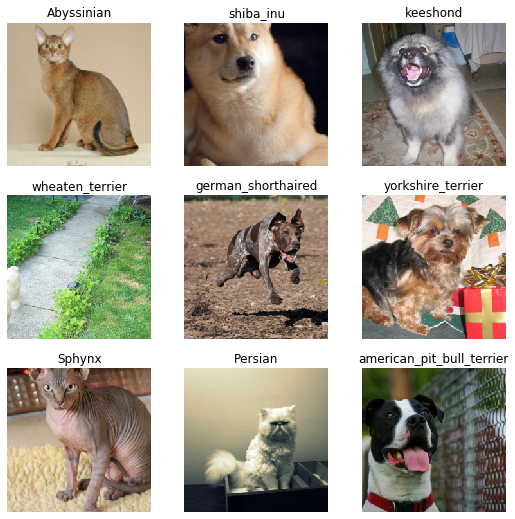

In [11]:
dls.show_batch()

SuggestedLRs(lr_min=0.012022644281387329, lr_steep=0.001737800776027143)

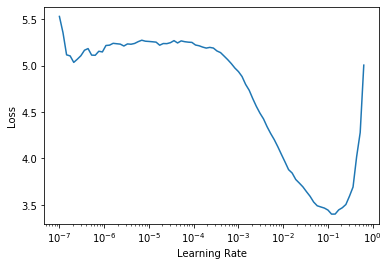

In [12]:
learn.lr_find()

In [13]:
learn.fine_tune(5)

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,1.167659,0.693181,0.205683,0.794317,03:11


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.622378,0.520346,0.158322,0.841678,04:17
1,0.549798,0.435346,0.136671,0.863329,04:17
2,0.391561,0.401840,0.131935,0.868065,04:20
3,0.298467,0.389295,0.123816,0.876184,04:19
4,0.234799,0.373669,0.119080,0.880920,04:19


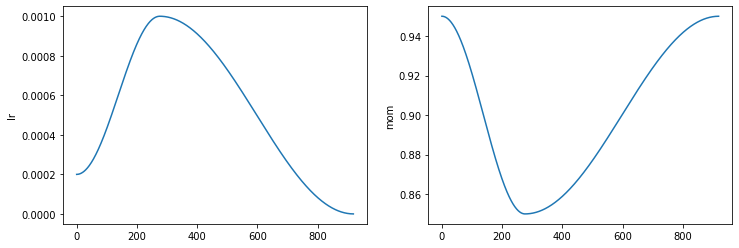

In [14]:
learn.recorder.plot_sched()

In [16]:
import timm
#timm.list_models()[:10]
timm.list_models('*efficientnet*')[:10]

['efficientnet_b0',
 'efficientnet_b1',
 'efficientnet_b1_pruned',
 'efficientnet_b2',
 'efficientnet_b2_pruned',
 'efficientnet_b2a',
 'efficientnet_b3',
 'efficientnet_b3_pruned',
 'efficientnet_b3a',
 'efficientnet_b4']